In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from preprocessing_pipeline import preprocess_data, numerical_columns, categorical_columns, columns_to_drop
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Data Loading and Processing
Load the dataset and show first few rows. Preprocess using pipeline

In [2]:
# Load the dataset
file_path = './marketing_campaign.csv'
df = pd.read_csv(file_path, sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# Apply preprocessing
processed_df = preprocess_data(df, numerical_columns, categorical_columns, columns_to_drop)

# Get the fitted pipeline from the preprocess_data output.
pipeline = preprocess_data.pipeline

# Save or inspect the processed data
processed_df.to_csv("marketing_campaign_processed_with_pipeline.csv", index=False)
print("Preprocessing complete!")
print(processed_df.head())

Removed 27 income outliers.
Preprocessing complete!
     Income  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  0.294551  0.976923   1.548034         1.708066         2.452673   
1 -0.259751 -0.872804  -0.637524        -0.722217        -0.651432   
2  0.927858  0.357383   0.568301        -0.177654         1.338847   
3 -1.185531 -0.872804  -0.562160        -0.659210        -0.505357   
4  0.301836 -0.392586   0.417573        -0.218159         0.151983   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0          1.483369      0.848775           0.358009         1.427545   
1         -0.634452     -0.733634          -0.167023        -1.127817   
2         -0.147597     -0.038918          -0.692055         1.427545   
3         -0.585766     -0.752932          -0.167023        -0.762765   
4         -0.001540     -0.559955           1.408073         0.332390   

   NumCatalogPurchases  ...  Marital_Status_Grouped_Couples  \
0             2.550438  .

# Find optimal value of K

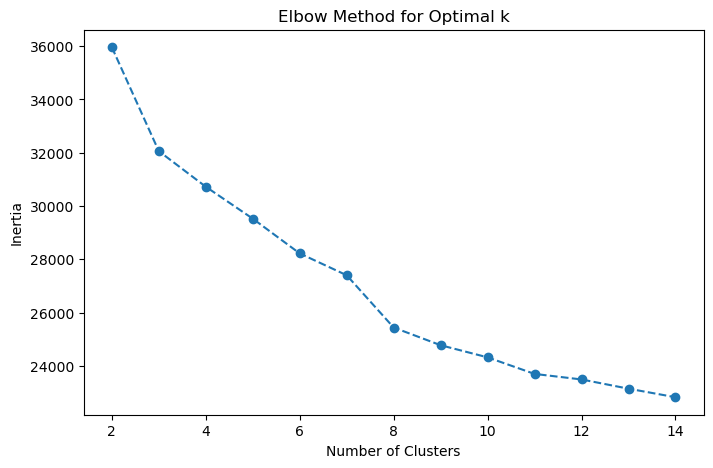

     k       inertia
0    2  35959.580338
1    3  32059.025580
2    4  30723.835997
3    5  29525.330741
4    6  28219.975229
5    7  27400.796268
6    8  25439.137355
7    9  24774.801825
8   10  24318.979949
9   11  23697.278105
10  12  23489.795984
11  13  23143.203846
12  14  22822.742387


In [4]:
inertia = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_df)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

res = pd.DataFrame({"k": K_range, "inertia": inertia})
print(res)

# Fit model with optimal value of K

In [5]:
# Set optimal number of clusters
optimal_k = 6  

# Fit K-Means without adding "Cluster" column yet
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(processed_df)  # Store cluster labels separately

# Compute evaluation metrics before modifying processed_df
inertia = kmeans.inertia_
sil_score = silhouette_score(processed_df, cluster_labels)  
db_score = davies_bouldin_score(processed_df, cluster_labels)

# Print results
print(f"Inertia: {inertia:.4f}")  # Lower is better
print(f"Silhouette Score: {sil_score:.4f}")  # Higher is better
print(f"Davies-Bouldin Score: {db_score:.4f}")  # Lower is better

# Now add the Cluster column to processed_df
processed_df["Cluster"] = cluster_labels  

# Calculate cluster distribution
cluster_distribution = processed_df["Cluster"].value_counts().sort_index()

# Calculate percentage distribution
cluster_percentage = (cluster_distribution / len(processed_df)) * 100

# Print cluster distribution
print("\nCluster Distribution (Absolute):")
print(cluster_distribution)

print("\nCluster Distribution (Percentage):")
print(cluster_percentage)

# Save the clustered data
processed_df.to_csv("clustered_data.csv", index=False)
print("✅ Clustering complete! Results saved to clustered_data.csv.")


Inertia: 28146.4172
Silhouette Score: 0.1091
Davies-Bouldin Score: 2.3059

Cluster Distribution (Absolute):
Cluster
0    335
1    404
2    263
3    168
4    380
5    663
Name: count, dtype: int64

Cluster Distribution (Percentage):
Cluster
0    15.137822
1    18.255761
2    11.884320
3     7.591505
4    17.171261
5    29.959331
Name: count, dtype: float64
✅ Clustering complete! Results saved to clustered_data.csv.



Cluster centroids in original scale:
         Income    MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  40106.020896   42.056716   2.656716        17.665672         4.083582   
1  62674.512376  563.425743  30.212871       169.584158        37.069307   
2  48767.395437  279.171103  11.536122        90.326996        17.574144   
3  80950.982143  890.089286  54.196429       485.238095        81.309524   
4  74032.913158  490.047368  76.323684       455.118421       111.715789   
5  32392.045249   37.776772   6.238311        23.764706         9.502262   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0          3.020896     11.755224           2.256716         1.826866   
1         30.754950     65.386139           2.762376         6.754950   
2         12.589354     48.703422           5.600760         5.768061   
3         65.672619     72.059524           1.047619         5.791667   
4         73.365789     81.042105           1.384211         4.7

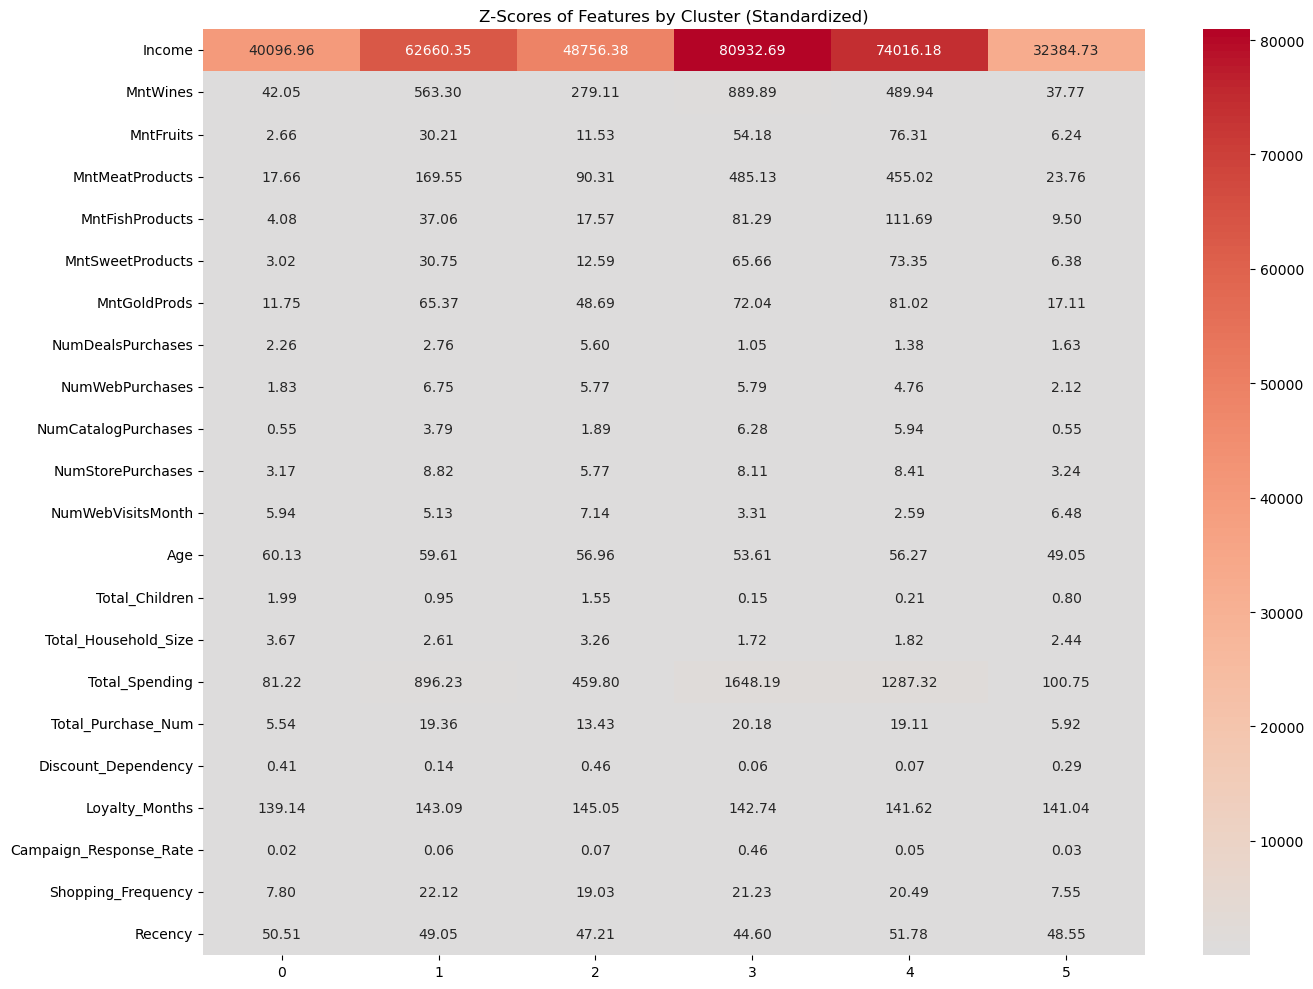

Z-Scores of features in each cluster (relative to overall mean and standard deviation):
         Income    MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  40096.958412   42.047213   2.656116        17.661680         4.082659   
1  62660.350245  563.298429  30.206044       169.545839        37.060931   
2  48756.375802  279.108020  11.533515        90.306586        17.570173   
3  80932.690202  889.888158  54.184182       485.128449        81.291151   
4  74016.184446  489.936636  76.306438       455.015581       111.690546   
5  32384.725840   37.768236   6.236901        23.759336         9.500115   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0          3.020213     11.752568           2.256206         1.826453   
1         30.748001     65.371364           2.761752         6.753424   
2         12.586509     48.692417           5.599495         5.766757   
3         65.657779     72.043241           1.047382         5.790358   
4         73.3

In [6]:
# Get Cluster Centroids and Calculate Relative Variance
centroids_scaled = kmeans.cluster_centers_

# Retrieve the StandardScaler from the pipeline
scaler = pipeline.named_steps['preprocessing'].named_transformers_['num'].named_steps['scaler']

# Convert centroids to original scale (only for numerical features)
num_features_idx = [processed_df.columns.get_loc(col) for col in numerical_columns]
centroids_numerical_scaled = centroids_scaled[:, num_features_idx]
centroids_numerical_unscaled = scaler.inverse_transform(centroids_numerical_scaled)

# Reconstruct full centroids with unscaled numerical values
centroids_unscaled = np.copy(centroids_scaled)
centroids_unscaled[:, num_features_idx] = centroids_numerical_unscaled
centroids_df = pd.DataFrame(centroids_unscaled, columns=processed_df.columns.drop('Cluster'))

print("\nCluster centroids in original scale:")
print(centroids_df)

# Calculate the overall mean and standard deviation for each feature
overall_mean = processed_df[numerical_columns].mean() #Change is here.
overall_std = processed_df[numerical_columns].std() #Change is here.
z_scores_centroids = (centroids_df[numerical_columns] - overall_mean) / overall_std

# Display Z-Scores
print("\nZ-Scores of features in each cluster (relative to overall mean and standard deviation):")
print(z_scores_centroids)

# Visualize Z-Scores as Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(z_scores_centroids.T, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Z-Scores of Features by Cluster (Standardized)')
plt.tight_layout()
plt.show()

# Print the Z-scores DataFrame
print("Z-Scores of features in each cluster (relative to overall mean and standard deviation):")
print(z_scores_centroids)

# Conclusion: Customer Segmentation Analysis Using K-Means Clustering  
The K-Means clustering model successfully identified distinct customer segments, allowing for personalized marketing, improved retention, and better resource allocation.

## 1. Key Cluster Characteristics  
Each cluster exhibits unique spending behaviors, household characteristics, and engagement levels.

- **Cluster 0**: Low-income group with minimal spending across categories. Moderate discount dependency.  
- **Cluster 1**: High-income, high spenders across all categories, particularly Wines and Meat. Low discount dependency.  
- **Cluster 2**: Mid-income, balanced spenders, moderate engagement in campaigns.  
- **Cluster 3**: Wealthiest group, extremely high spending across all product categories. High campaign engagement.  
- **Cluster 4**: High-income, strong focus on Meat, Fish, and Sweet products. Some engagement with campaigns.  
- **Cluster 5**: Lowest-income group, lowest spending. Moderate discount dependency but low engagement in campaigns.  

## 2. Business Implications & Strategy  
The segmentation insights provide a foundation for targeted marketing strategies:

- **High-Spenders (Clusters 1, 3, 4)**  
  These customers prioritize quality over discounts.  
  **Focus on premium product offerings, loyalty rewards, and exclusive events.**  

- **Price-Sensitive Shoppers (Clusters 0, 5)**  
  Lower spenders with higher dependency on discounts.  
  **Optimize discount campaigns to increase engagement and spending.**  

- **Balanced Consumers (Cluster 2)**  
  Represent the general customer base with moderate campaign response.  
  **Use broad promotional strategies combining discounts and premium products.**  

- **Highly Engaged Customers (Cluster 3)**  
  Most engaged in campaigns with high purchase frequency.  
  **Offer exclusive loyalty programs, personalized marketing, and VIP memberships.**  

## 3. Final Recommendations  
- **Personalized Marketing Campaigns:** Tailor campaigns based on spending behavior and engagement levels.  
- **Loyalty & Retention Programs:** Offer tiered rewards for high-value customers (Clusters 1 & 3).  
- **Discount Strategies:** Use targeted discounts for price-sensitive groups (Clusters 0 & 5) instead of blanket discounts.  
- **Product Recommendations:** Curate product bundles based on spending behavior (e.g., premium bundles for Cluster 3).  

## Final Takeaway  
This clustering analysis provides a clear segmentation of customers, allowing businesses to optimize marketing, increase customer retention, and drive revenue growth. Further refinements can be made by incorporating additional behavioral data or testing marketing strategies on each segment.
